In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

from util.detectors.fkdn_detector import FKDN_Detector
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from util.create_artificial_dataset import create_artificial_dataset, corrupt_iln

import matplotlib.pyplot as plt
import numpy as np

from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS

plt.rcParams.update(FONT_SIZE_PARAMS) 

In [2]:
def train_evaluate_classifier(x_train, y_train, x_test, y_test, clf):

    assert 'label' not in x_train.columns 
    assert 'noisy_label' not in x_train.columns 

    assert 'label' not in x_test.columns 
    assert 'noisy_label' not in x_test.columns 

    

    clf.fit(x_train, y_train)

    y_true = y_test
    y_pred = clf.predict(x_test)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)

    return precision, recall, f1, acc

In [3]:
base_estimator = DecisionTreeClassifier(max_depth=1)

adaboost_clf = AdaBoostClassifier(estimator=base_estimator)

In [4]:
df = pd.read_csv("../../datasets/music/preprocessed_music_most_values.csv")

runs = []


for j in range(1):
    results = []
    clean = df.copy()
    datasets = []

    for i in range(4):

        clean_train, clean_test = train_test_split(clean, test_size=0.2, random_state=42)
        
        _, original_clean_test = train_test_split(df, test_size=0.2, random_state=42)

        clean_train = clean_train.reset_index(drop=True)

        corrupted = corrupt_iln(clean_train, teacher_model=RandomForestClassifier(), dataset="music_most_values")
        print(f'noise rate = {len(corrupted[corrupted["label"] != corrupted["noisy_label"]]) / len(corrupted)}')
        corrupted = corrupted.drop(["mislabeling_probability", "label"], axis=1).rename(columns={'noisy_label': 'label'})

        datasets.append((clean_train, corrupted))

        clean_precision, clean_recall, clean_f1, clean_acc = train_evaluate_classifier(clean_train.drop("label", axis=1),
                                                                                    clean_train["label"],
                                                                                    clean_test.drop("label", axis=1),
                                                                                    clean_test["label"],
                                                                                    clf=adaboost_clf)
        
        corrupted_precision, corrupted_recall, corrupted_f1, corrupted_acc = train_evaluate_classifier(corrupted.drop("label", axis=1),
                                                                                    corrupted["label"],
                                                                                    clean_test.drop("label", axis=1),
                                                                                    clean_test["label"],
                                                                                    clf=adaboost_clf)
        corrupted_precision_against_original_clean, corrupted_recall_against_original_clean, corrupted_f1_against_original_clean, corrupted_acc_against_original_clean = train_evaluate_classifier(corrupted.drop("label", axis=1),
                                                                                    corrupted["label"],
                                                                                    original_clean_test.drop("label", axis=1),
                                                                                    original_clean_test["label"],
                                                                                    clf=adaboost_clf)
        
        results.append({'clean_f1': clean_f1,
                        'corrupted_f1': corrupted_f1, 
                        'corrupted_f1_against_original_clean': corrupted_f1_against_original_clean})
        clean = corrupt_iln(clean.reset_index(drop=True), teacher_model=RandomForestClassifier(), dataset="music_most_values").drop(["mislabeling_probability", "label"], axis=1).rename(columns={'noisy_label': 'label'})
    runs.append(results)

noise rate = 0.02019165383829155
noise rate = 0.0888391050591774
noise rate = 0.0990016812472101
noise rate = 0.06661159851983496


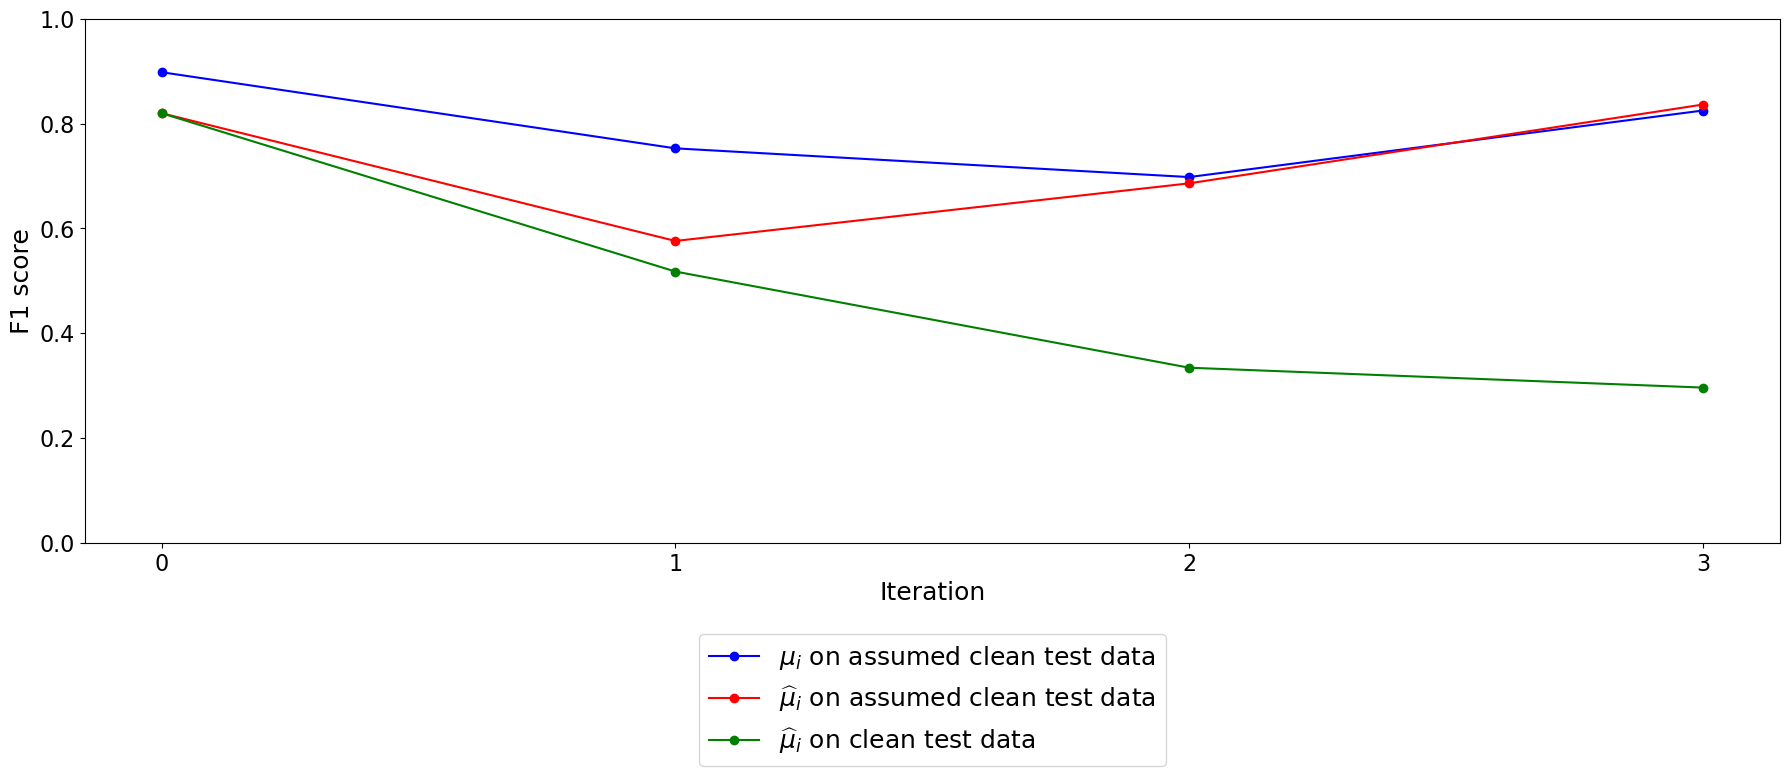

In [5]:

clean_f1_1 = []
corrupted_f1_1 = []
corrupted_f1_against_original_clean_1 = []

clean_f1_2 = []
corrupted_f1_2 = []
corrupted_f1_against_original_clean_2 = []

clean_f1_3 = []
corrupted_f1_3 = []
corrupted_f1_against_original_clean_3 = []

clean_f1_4 = []
corrupted_f1_4 = []
corrupted_f1_against_original_clean_4 = []

for run in runs:
    clean_f1_1.append(run[0]["clean_f1"])
    corrupted_f1_1.append(run[0]["corrupted_f1"])
    corrupted_f1_against_original_clean_1.append(run[0]["corrupted_f1_against_original_clean"])

    clean_f1_2.append(run[1]["clean_f1"])
    corrupted_f1_2.append(run[1]["corrupted_f1"])
    corrupted_f1_against_original_clean_2.append(run[1]["corrupted_f1_against_original_clean"])

    clean_f1_3.append(run[2]["clean_f1"])
    corrupted_f1_3.append(run[2]["corrupted_f1"])
    corrupted_f1_against_original_clean_3.append(run[2]["corrupted_f1_against_original_clean"])

    clean_f1_4.append(run[3]["clean_f1"])
    corrupted_f1_4.append(run[3]["corrupted_f1"])
    corrupted_f1_against_original_clean_4.append(run[3]["corrupted_f1_against_original_clean"])

clean_f1 = [np.mean(clean_f1_1), np.mean(clean_f1_2), np.mean(clean_f1_3), np.mean(clean_f1_4)]
corrupted_f1 = [np.mean(corrupted_f1_1), np.mean(corrupted_f1_2), np.mean(corrupted_f1_3), np.mean(corrupted_f1_4)]
corrupted_f1_against_original_clean = [
    np.mean(corrupted_f1_against_original_clean_1),
    np.mean(corrupted_f1_against_original_clean_2),
    np.mean(corrupted_f1_against_original_clean_3),
    np.mean(corrupted_f1_against_original_clean_4),
]

plt.figure(figsize=FIG_SIZE)


plt.plot(clean_f1, color="blue", marker='o', label=r'$\mu_i$ on assumed clean test data')
plt.plot(corrupted_f1, color="red", marker='o', label=r'$\widehat{\mu}_i$ on assumed clean test data')
plt.plot(corrupted_f1_against_original_clean, color="green", marker='o', label=r'$\widehat{\mu}_i$ on clean test data')


plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=1)

plt.xlabel("Iteration")
plt.ylabel("F1 score")
plt.ylim(0, 1)
plt.xticks([0, 1, 2, 3])

plt.tight_layout()  
plt.show()


# Music precision - dexter precision

In [6]:
import pandas as pd
import json
import matplotlib.pyplot as plt

from util.flatten_evaluation_items import flatten_evaluation_items

from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS

plt.rcParams.update({
    'font.size':20 
}) 

In [7]:
conf_learn_fkdn_results_path = '../../results/evaluation_music/conf_learn_fkdn_evaluation.json'
cvcf_results_path = '../../results/evaluation_music/cvcf.json'
harf_results_path = '../../results/evaluation_music/harf.json'

with open(conf_learn_fkdn_results_path, "r") as f:
    conf_learn_fkdn_data = json.load(f)

with open(cvcf_results_path, "r") as f:
    cvcf_data = json.load(f)

with open(harf_results_path, "r") as f:
    harf_data = json.load(f)

full_data_music = conf_learn_fkdn_data + cvcf_data + harf_data
full_data_music = [flatten_evaluation_items(data) for data in full_data_music]

df_music = pd.DataFrame(full_data_music)

df_music

,dataset,detector,noise_rate,time,cleaning_accuracy,cleaning_precision,cleaning_recall,cleaning_f1,cleaning_f05,cleaning_pon,cleaning_fp_proportion
0,music_most_values_rf_corrupted,conf_learn,0.020335,50.475281,0.983493,0.759855,0.275234,0.404096,0.561960,0.739520,4.184085
1,music_most_values_rf_corrupted,arguable_conf_learn,0.020335,49.641122,0.986270,0.667174,0.648121,0.657509,0.663274,0.646838,11.665123
2,music_most_values_rf_corrupted,fkdn,0.020335,3399.868947,0.988960,0.699185,0.802232,0.747172,0.717620,0.678850,14.973996
3,music_most_values_svm_corrupted,conf_learn,0.052855,47.777849,0.947121,0.497447,0.043064,0.079265,0.159936,0.444592,0.728029
4,music_most_values_svm_corrupted,arguable_conf_learn,0.052855,50.000274,0.944268,0.452564,0.259645,0.329976,0.394013,0.399709,2.120674
5,music_most_values_svm_corrupted,fkdn,0.052855,3457.674416,0.952845,0.597958,0.329166,0.424598,0.514011,0.545103,2.542237
6,music_most_values_tree_corrupted,conf_learn,0.032143,46.076833,0.977726,0.811591,0.399855,0.535754,0.672993,0.779448,1.995318
7,music_most_values_tree_corrupted,arguable_conf_learn,0.032143,51.865663,0.982502,0.770197,0.649361,0.704636,0.742561,0.738054,8.420865
8,music_most_values_tree_corrupted,fkdn,0.032143,3618.927481,0.987698,0.777518,0.864708,0.818799,0.793521,0.745375,11.086401
9,music_most_values_rf_corrupted,cvcf,0.020300,2.81579634745916,0.990200,0.738600,0.788300,0.762600,0.748000,0.718300,29.915800


In [8]:
conf_learn_fkdn_results_path = '../../results/evaluation_dexter/conf_learn_fkdn_evaluation.json'
cvcf_results_path = '../../results/evaluation_dexter/cvcf.json'
harf_results_path = '../../results/evaluation_dexter/harf.json'

with open(conf_learn_fkdn_results_path, "r") as f:
    conf_learn_fkdn_data = json.load(f)

with open(cvcf_results_path, "r") as f:
    cvcf_data = json.load(f)

with open(harf_results_path, "r") as f:
    harf_data = json.load(f)

full_data_dexter = conf_learn_fkdn_data + cvcf_data + harf_data
full_data_dexter = [flatten_evaluation_items(data) for data in full_data_dexter]

df_dexter = pd.DataFrame(full_data_dexter)

df_dexter

,dataset,detector,noise_rate,time,cleaning_accuracy,cleaning_precision,cleaning_recall,cleaning_f1,cleaning_f05,cleaning_pon,cleaning_fp_proportion
0,dexter_rf_corrupted,conf_learn,0.095248,101.62092,0.913534,0.616559,0.243871,0.349502,0.472226,0.521311,2.377222
1,dexter_rf_corrupted,fkdn,0.095248,283.184695,0.892153,0.448254,0.572905,0.502971,0.468647,0.353006,2.310513
2,dexter_svm_corrupted,conf_learn,0.176617,102.772583,0.830449,0.689930,0.072665,0.131483,0.255632,0.513313,1.232032
3,dexter_svm_corrupted,fkdn,0.176617,275.937803,0.831085,0.536487,0.320606,0.401359,0.472813,0.359870,1.182985
4,dexter_tree_corrupted,conf_learn,0.119051,94.416848,0.908647,0.712018,0.390662,0.504513,0.611427,0.592967,1.958132
5,dexter_tree_corrupted,fkdn,0.119051,269.158563,0.884469,0.511323,0.667594,0.579101,0.536437,0.392272,2.150054
6,dexter_rf_corrupted,cvcf,0.095200,52.2294309139252,0.917100,0.558900,0.616400,0.586300,0.569600,0.463700,8.174600
7,dexter_svm_corrupted,cvcf,0.176600,41.8907680511475,0.840200,0.591900,0.306500,0.403900,0.499000,0.415300,1.158000
8,dexter_tree_corrupted,cvcf,0.119100,43.5718929767609,0.916000,0.627900,0.722200,0.671700,0.644700,0.508800,8.988000
9,dexter_rf_corrupted,harf,0.095200,12.4208654205004,0.924900,0.625000,0.529200,0.573100,0.603200,0.529800,10.022300


In [9]:
detectors = ['conf_learn', 'fkdn', 'cvcf', 'harf']
teacher_models = ["rf", "svm", "tree"]

results = []

for detector in detectors:
    for teacher in teacher_models:
        music_precision = df_music[(df_music["dataset"].str.contains(f"music_most_values_{teacher}")) & (df_music["detector"] == detector)]["cleaning_precision"].to_numpy()[0]
        dexter_precision = df_dexter[(df_dexter["dataset"].str.contains(f"dexter_{teacher}")) & (df_dexter["detector"] == detector)]["cleaning_precision"].to_numpy()[0]

        results.append((detector, teacher, music_precision - dexter_precision))

In [10]:
lookup = {
    "conf_learn": "Confident Learning",
    "fkdn": "FKDN",
    "cvcf": "CVCF",
    "harf": "HARF"
}

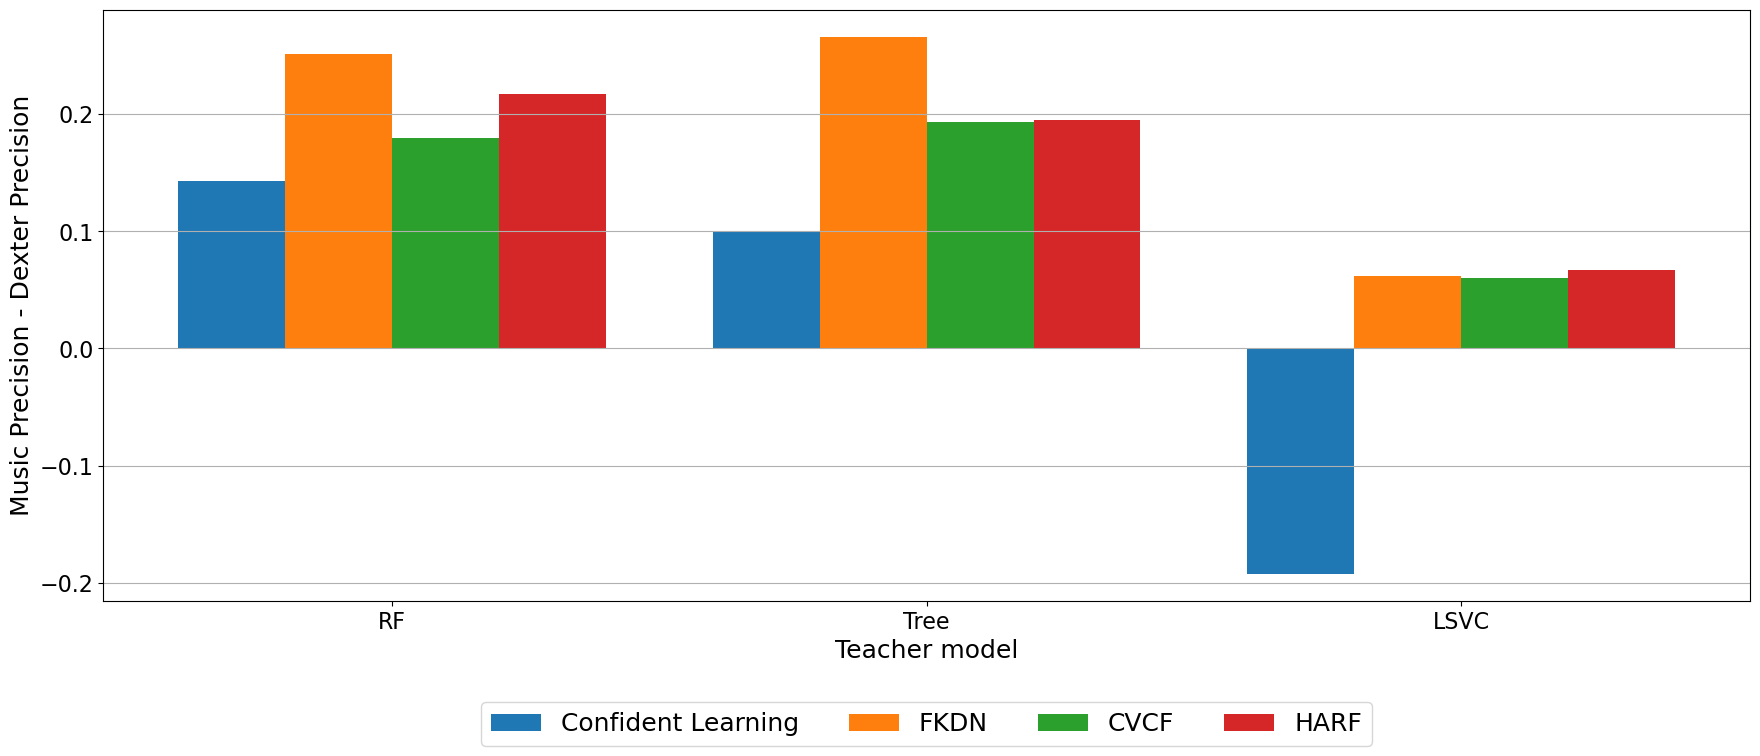

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df = pd.DataFrame(results, columns=['method', 'model', 'value'])
df['method'] = df['method'].replace(lookup)

models = df['model'].unique()
methods = df['method'].unique()

bar_width = 0.2
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=FIG_SIZE)

for i, method in enumerate(methods):
    method_values = df[df['method'] == method].set_index('model').loc[models]['value']
    order = ['rf', 'tree', 'svm']

    method_values = method_values.reindex(order)
    ax.bar(x + i * bar_width, method_values, width=bar_width, label=method)

ax.set_xlabel('Teacher model')
ax.set_ylabel('Music Precision - Dexter Precision')
ax.set_xticks(x + bar_width * (len(methods) - 1) / 2)
ax.set_xticklabels(["RF", "Tree", "LSVC"])
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=4)
ax.grid(True, axis='y')

plt.tight_layout()
plt.show()
